# <center> Change-Point Estimation on MNIST-Seq with XSCPE </center>
The XSCPE algorithm provides an approach to end-to-end learning that allows one to jointly learn a feature
representation from unlabeled sequences (with or without labeled sequences) and predict change points in unlabeled sequences. It is domain-agnostic and can be used with any ratio of labeled to unlabeled sequences, gracefully
adjusting to the amount of supervision.

In this notebook we'll set up and train a LeNet-5 convolutional kernel network (see [Jones et al., 2019](https://arxiv.org/pdf/1903.08131.pdf) for how LeNet-5 was translated to a convolutional kernel network) on the dataset MNIST-seq using XSCPE. 

## 1 Setting up the data
There are five main items we need to set up: the data, model, training parameters, and results and optimizer objects. First we'll set up the data. For this we need to first load the default parameters and the MNIST data loader code:

In [1]:
import sys
sys.path.append('..')

from src import default_params as defaults
import src.data_loaders.mnist_seq as mnist_seq

There are several parameters we need to set:
- data_path: The directory where the data resides or will reside. For MNIST if the data doesn't already exist there it will be automatically downloaded and saved there.
- num_labeled: The number of labeled sequences in the training set.
- num_train: The total (labeled+unlabeled) number of sequences in the training set. If None, it will be approximately 500.
- seed: The random seed to use when generating the sequences of observations.

In [2]:
data_path = '../data/MNIST'
num_labeled = 0  
num_train = None
seed = 3

In [3]:
import numpy as np
import random
import torch
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [4]:
# Create the data loaders
train_loader, train_labeled_loader, train_unlabeled_loader, valid_loader, test_loader = \
    mnist_seq.get_dataloaders(data_path=data_path, num_labeled=num_labeled, 
                              num_train=num_train, num_workers=0, seed=seed)
print('Size of training set:', len(train_loader.dataset))

Number of labeled sequences being used: 0
Size of training set: 498


We have five different data loaders: 
- train_loader: Data loader that contains both the labeled and unlabeled observations in the training set
- train_labeled_loader: Data loader that contains the labeled observations in the training set
- train_unlabeled_loader: Data loader that contains the unlabeled observations in the training set
- valid_loader: Data loader that contains the observations in the validation set
- test_loader: Data loader that contains the observations in the test set

Now we will create a Data object that contains the relevant data loaders and which will be used by XSCPE:

In [5]:
from src.opt import opt_structures
data = opt_structures.Data(train_labeled_loader, train_unlabeled_loader, valid_loader, test_loader)

## 2 Setting up the model
Next we'll set up the model. The model is specified in a config file. This file is loaded and parsed, and then the model is initialized. You can alternatively use a neural network and pass the initialized network to `opt_structures.Model()` below. 

In [6]:
from src.model.ckn import parse_config, net

There are two parameters we will change from the version of the network specified in the config file:
1. The number of filters at each layer
2. The bandwidths of the kernels

We'll use a small model, so we'll set the number of filters per layer to 32. The bandwidth of 0.7 was found by hold-out validation.

In [7]:
num_filters = 32
bandwidth = 0.7

In [8]:
# Load the parameters of the network
params = parse_config.load_config('../cfg/lenet-5_ckn.cfg')

# Change the number of filters per layer and the bandwidths of the kernels
nlayers = len(params['num_filters'])
params['num_filters'] = [num_filters] * nlayers
params['patch_sigma'] = [bandwidth] * nlayers

# Create the network
layers = parse_config.create_layers(params)
model = net.CKN(layers).to(defaults.device)

# Initialize the network
model.init(train_loader)
print('Done with initialization')

Initializing layer 0
Initializing layer 1
Initializing layer 2
Initializing layer 3
Initializing layer 4
Initializing layer 5
Done with initialization


The network has now been initialized. We just need to create an object of the `Model` class for XSCPE. We'll save the model after training to the file `../output/temp_model.pickle`.

In [9]:
import os

save_file = os.path.join('..', 'output', 'temp')
model = opt_structures.Model(model, save_path=save_file + '_model.pickle')

## 3 Setting up the parameters
Finally, we'll set up the parameters. There are a large number of parameters that we can specifiy for XSCPE. These include the following:

In [10]:
batch_size=50                 # Batch size to use when training
ckn = True                    # Whether the network is a CKN 
epsilon = 10**-3              # Epsilon in the first penalty term
eval_test_every = 1           # Number of iterations between evaluations of the performance
lambda_cov = 2**3             # Penalty on sqrt(tr(empirical covariance)+epsilon)
lr = 2**-3                    # Learning rate
min_dist = 1                  # Minimum allowable distance between change points
num_classes = 10              # Number of classes in the dataset
num_iters = 10                # Number of iterations for which it will run
project = True                # Whether to project the patches onto the unit sphere at each layer
save_every = 50               # How often to save the model, parameters, and results (after how many iterations)
save_path = save_file + '_params.pickle' # File where the parameters will be saved
train_w_layers = [0, 2, 4, 5] # Layers of the network whose parameters should be trained

We'll run XSCPE for 10 iterations.

In [11]:
params = opt_structures.Params(batch_size=batch_size, ckn=ckn, epsilon=epsilon, 
                               eval_test_every=eval_test_every, lambda_cov=lambda_cov, lr=lr, 
                               min_dist=min_dist, num_classes=num_classes, num_iters=num_iters, 
                               project=project,save_every=save_every, save_path=save_path)

## 4 Setting up the results and training objects
The last things we need to set up are the object that will store the results and the optimizer object.

In [12]:
from src.opt import train_network

save_path = save_file + '_results.pickle'
results = opt_structures.Results(save_path=save_path)

optimizer = train_network.TrainSupervised(data, model, params, results)

## 5 Training with XSCPE
Now we're ready to train with XSCPE! While we run it for 10 iterations here, in practice one would likely want to run it for longer.

In [13]:
optimizer.train()

Iteration 	 Test Frobenius 	 Test loss 	 Train-labeled Frobenius 	 Train-labeled loss 	 Train-unlabeled Frobenius 	 Train-unlabeled loss
0 		 0.9181 	 -23.0291 	000inf 	 000inf 	 0.8381 	 -12.5318
1 		 0.6964 	 -30.6994 	000inf 	 000inf 	 0.6084 	 -28.2574
2 		 0.5262 	 -37.5683 	000inf 	 000inf 	 0.5165 	 -31.2032
3 		 0.3962 	 -35.4293 	000inf 	 000inf 	 0.3592 	 -33.0190
4 		 0.4153 	 -44.3558 	000inf 	 000inf 	 0.3910 	 -38.6422
5 		 0.4637 	 -40.2805 	000inf 	 000inf 	 0.3680 	 -37.0613
6 		 0.3533 	 -49.2233 	000inf 	 000inf 	 0.3201 	 -43.4364
7 		 0.3616 	 -48.5601 	000inf 	 000inf 	 0.3109 	 -43.9347
8 		 0.3176 	 -54.3152 	000inf 	 000inf 	 0.2926 	 -48.6945
9 		 0.2315 	 -53.2958 	000inf 	 000inf 	 0.2677 	 -48.9212
10 		 0.2836 	 -61.0972 	000inf 	 000inf 	 0.2650 	 -54.1149
Done training. Saving final results.
10 		 0.2836 	 -61.0972 	000inf 	 000inf 	 0.2650 	 -54.1149


## 6 Examining the results
Now we can load and plot the results. First, we can look at the Frobenius distance between the estimated and true segmentations across iterations:

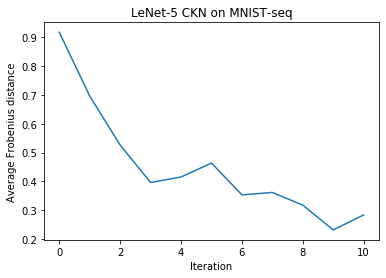

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

results = pickle.load(open(save_file + '_results.pickle', 'rb'))

plt.plot(list(results['test_frobenius'].keys()), list(results['test_frobenius'].values()))
plt.xlabel('Iteration')
plt.ylabel('Average Frobenius distance')
plt.title('LeNet-5 CKN on MNIST-seq')
plt.show()

We can also visualize the resultant features projected to 2D using t-SNE. Here we first create a grid. For each square in the grid, the code checks whether any image’s t-SNE representation lies in that square. If any such images exist, it chooses one at random and displays the original image in that square. The images are color-coded according to the ground-truth labels.

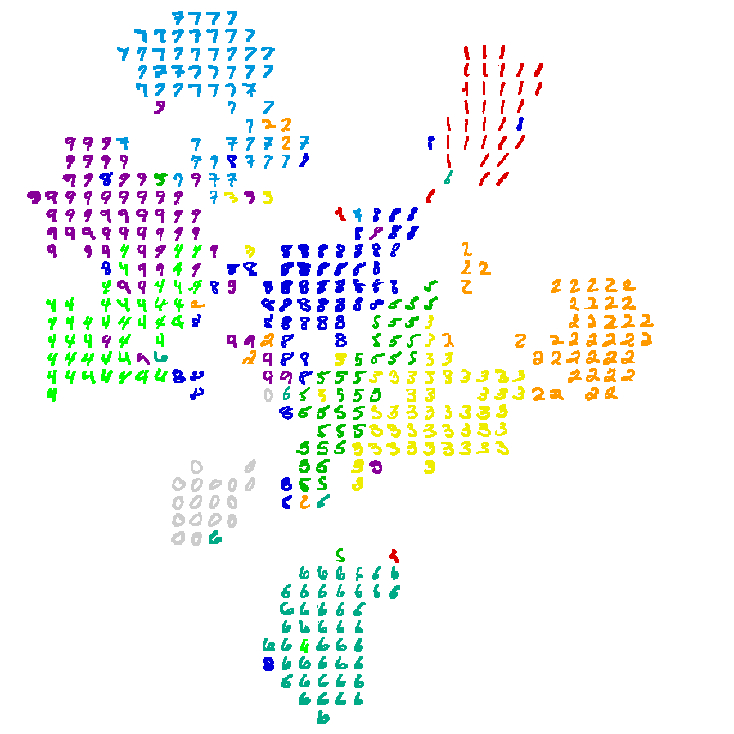

In [15]:
import matplotlib
import numpy as np
import torch

sys.path.append('../src/opt')

import opt_utils
import tsne_visualization

matplotlib.rcParams['figure.figsize'] = (10, 10)

# Load the trained model
model = opt_structures.Model()
model.load(save_file + '_model_10.pickle')

# Compute the features and labels for 4096 observations
torch.cuda.empty_cache()
x_unlab_all = []
features_all = []
y_unlab_all = []
for i in range(20):
    x_unlab, _, _, y_unlab_truth, _, _ = next(iter(train_unlabeled_loader))
    x_unlab_all.append(x_unlab[0])
    features = opt_utils.compute_features(x_unlab, model)
    features_all.append(features[0])
    y_unlab_all.append(y_unlab_truth[0])

x_unlab = torch.cat(x_unlab_all)
x_unlab = ((x_unlab*0.3081+0.1307)).unsqueeze(1)
features = torch.cat(features_all)
y_unlab_truth = torch.cat(y_unlab_all)

# Compute the embeddings
embeddings = tsne_visualization.compute_embedding(features, perplexity=30)
embeddings = (embeddings - np.min(embeddings))
embeddings /= np.max(embeddings)

# Plot the embeddings
tsne_visualization.display_color(embeddings, x_unlab, y_unlab_truth, save_file=None)